# Control probing for untrained model

The following notebook contains probing control tests performed for randomly initialized untrained model.

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-untrained'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom = meta['stoi'], meta['itos'], meta['stom']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
str_to_moves = lambda s: ''.join([stom[c] for c in s])
ids_to_moves = lambda l: ''.join([stom[itos[i]] for i in l])

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [15]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.0646
Epoch   1: 1.0012
Epoch   2: 0.9570
Epoch   3: 0.9263
Epoch   4: 0.9043
Epoch   5: 0.8876
Epoch   6: 0.8739
Epoch   7: 0.8623
Epoch   8: 0.8522
Epoch   9: 0.8429
Epoch  10: 0.8345
Epoch  11: 0.8268
Epoch  12: 0.8194
Epoch  13: 0.8126
Epoch  14: 0.8062
Epoch  15: 0.8002
Epoch  16: 0.7943
Epoch  17: 0.7889
Epoch  18: 0.7836
Epoch  19: 0.7787
Epoch  20: 0.7739
Epoch  21: 0.7694
Epoch  22: 0.7650
Epoch  23: 0.7608
Epoch  24: 0.7568
Epoch  25: 0.7529
Epoch  26: 0.7491
Epoch  27: 0.7455
Epoch  28: 0.7420
Epoch  29: 0.7387
Epoch  30: 0.7353
Epoch  31: 0.7323
Epoch  32: 0.7292
Epoch  33: 0.7262
Epoch  34: 0.7233
Epoch  35: 0.7205
Epoch  36: 0.7178
Epoch  37: 0.7152
Epoch  38: 0.7127
Epoch  39: 0.7102
Epoch  40: 0.7078
Epoch  41: 0.7053
Epoch  42: 0.7031
Epoch  43: 0.7008
Epoch  44: 0.6987
Epoch  45: 0.6966
Epoch  46: 0.6945
Epoch  47: 0.6924
Epoch  48: 0.6905
Epoch  49: 0.6886
Epoch  50: 0.6867
Epoch  51: 0.6849
Epoch  52: 0.6831
Epoch  53: 0.6813
Epoch  54: 0.6796
Epoch  55:

Predict number of pieces in each column

In [16]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 1.9187
Epoch   1: 1.8666
Epoch   2: 1.8284
Epoch   3: 1.7993
Epoch   4: 1.7755
Epoch   5: 1.7548
Epoch   6: 1.7361
Epoch   7: 1.7189
Epoch   8: 1.7028
Epoch   9: 1.6878
Epoch  10: 1.6734
Epoch  11: 1.6599
Epoch  12: 1.6470
Epoch  13: 1.6346
Epoch  14: 1.6229
Epoch  15: 1.6116
Epoch  16: 1.6009
Epoch  17: 1.5906
Epoch  18: 1.5807
Epoch  19: 1.5711
Epoch  20: 1.5620
Epoch  21: 1.5532
Epoch  22: 1.5446
Epoch  23: 1.5363
Epoch  24: 1.5284
Epoch  25: 1.5207
Epoch  26: 1.5132
Epoch  27: 1.5060
Epoch  28: 1.4991
Epoch  29: 1.4921
Epoch  30: 1.4855
Epoch  31: 1.4792
Epoch  32: 1.4729
Epoch  33: 1.4667
Epoch  34: 1.4608
Epoch  35: 1.4550
Epoch  36: 1.4494
Epoch  37: 1.4439
Epoch  38: 1.4384
Epoch  39: 1.4332
Epoch  40: 1.4281
Epoch  41: 1.4231
Epoch  42: 1.4181
Epoch  43: 1.4134
Epoch  44: 1.4086
Epoch  45: 1.4040
Epoch  46: 1.3995
Epoch  47: 1.3950
Epoch  48: 1.3907
Epoch  49: 1.3865
Epoch  50: 1.3822
Epoch  51: 1.3782
Epoch  52: 1.3742
Epoch  53: 1.3703
Epoch  54: 1.3664
Epoch  55:

Predict number of pieces in each row

In [17]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.0472
Epoch   1: 1.9652
Epoch   2: 1.8991
Epoch   3: 1.8451
Epoch   4: 1.8005
Epoch   5: 1.7629
Epoch   6: 1.7301
Epoch   7: 1.7010
Epoch   8: 1.6748
Epoch   9: 1.6505
Epoch  10: 1.6280
Epoch  11: 1.6069
Epoch  12: 1.5871
Epoch  13: 1.5682
Epoch  14: 1.5504
Epoch  15: 1.5334
Epoch  16: 1.5172
Epoch  17: 1.5016
Epoch  18: 1.4867
Epoch  19: 1.4725
Epoch  20: 1.4588
Epoch  21: 1.4456
Epoch  22: 1.4330
Epoch  23: 1.4208
Epoch  24: 1.4091
Epoch  25: 1.3977
Epoch  26: 1.3868
Epoch  27: 1.3763
Epoch  28: 1.3661
Epoch  29: 1.3562
Epoch  30: 1.3467
Epoch  31: 1.3376
Epoch  32: 1.3286
Epoch  33: 1.3199
Epoch  34: 1.3116
Epoch  35: 1.3036
Epoch  36: 1.2957
Epoch  37: 1.2880
Epoch  38: 1.2807
Epoch  39: 1.2735
Epoch  40: 1.2666
Epoch  41: 1.2597
Epoch  42: 1.2532
Epoch  43: 1.2467
Epoch  44: 1.2405
Epoch  45: 1.2345
Epoch  46: 1.2285
Epoch  47: 1.2227
Epoch  48: 1.2172
Epoch  49: 1.2118
Epoch  50: 1.2065
Epoch  51: 1.2013
Epoch  52: 1.1962
Epoch  53: 1.1913
Epoch  54: 1.1866
Epoch  55:

### Test linear probes

In [18]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [19]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [20]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.7796, 0.7902, 0.7839, 0.7464, 0.8216, 0.8616, 0.9071, 0.7459, 0.7550,
        0.7345, 0.6965, 0.7778, 0.8196, 0.8797, 0.7147, 0.7169, 0.6932, 0.6511,
        0.7295, 0.7632, 0.8370, 0.6891, 0.6697, 0.6709, 0.6430, 0.6983, 0.7310,
        0.8046, 0.6525, 0.6401, 0.6381, 0.5991, 0.6452, 0.6767, 0.7493, 0.6165,
        0.6137, 0.6313, 0.6335, 0.6178, 0.6270, 0.6596], device='cuda:0')

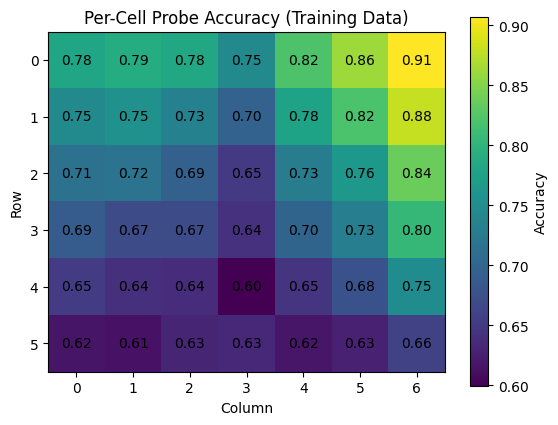

In [21]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [22]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.7970, 0.7902, 0.7939, 0.7489, 0.8103, 0.8573, 0.9086, 0.7415, 0.7526,
        0.7320, 0.6860, 0.7664, 0.8118, 0.8890, 0.7030, 0.7135, 0.6728, 0.6432,
        0.7246, 0.7558, 0.8430, 0.6834, 0.6623, 0.6564, 0.6216, 0.6823, 0.7172,
        0.8050, 0.6448, 0.6427, 0.6348, 0.6099, 0.6480, 0.6792, 0.7331, 0.5936,
        0.6195, 0.6158, 0.6226, 0.6142, 0.6311, 0.6459], device='cuda:0')

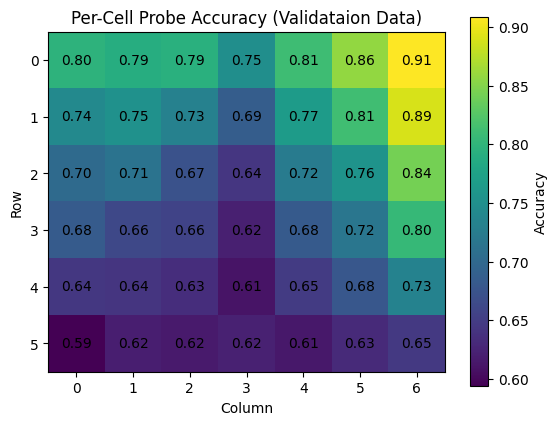

In [23]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [24]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.6671, 0.6726, 0.6729, 0.6552, 0.6389, 0.6311, 0.6738],
       device='cuda:0')

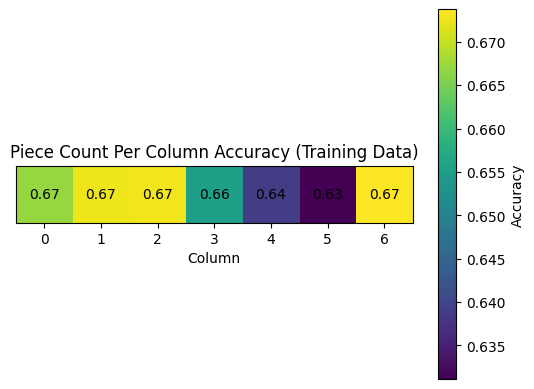

In [25]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [26]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.6617, 0.6416, 0.6617, 0.6522, 0.6527, 0.6290, 0.6538],
       device='cuda:0')

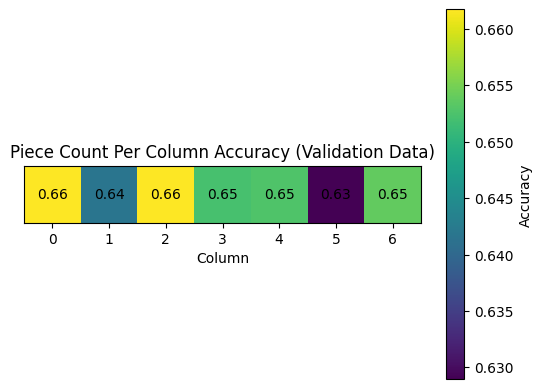

In [27]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [28]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.6625, 0.6183, 0.6348, 0.6356, 0.6099, 0.6149], device='cuda:0')

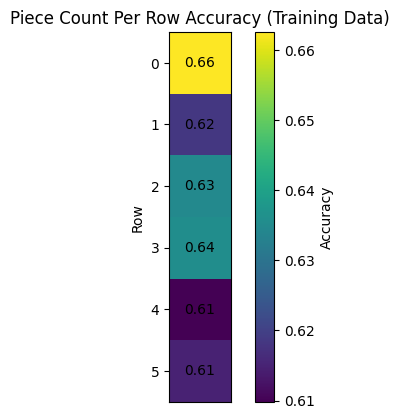

In [29]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [30]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.6638, 0.6189, 0.6448, 0.6390, 0.6041, 0.6105], device='cuda:0')

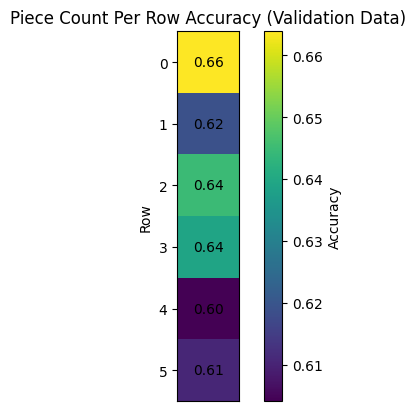

In [31]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)